# NLP Prediction
*__The Data__*: This notebook uses data on New York City apartments listed on Craigslist. This is not a Kaggle or publically available data set, but one made by my own AWS pipeline which is described [in this GitHub repo](https://github.com/scochran3/LazyApartment). The pipeline is created by a series of AWS Lambda functions

*__The Problem__*: Most apartment listings on Craigslist for apartments list how many bedrooms the apartment possesses. Note the fact that we said most but not all. For those that don't have bedrooms it be nice if we could predict, based on the title of the ad, how many bedrooms the apartment has. Many of the listings are titled something like "Beautiful 2BD In Brooklyn" where it should be easy enough to extract out the response.

*__Why This Is an Issue__*: Many algorithms won't play nice with missing data, so it be nice if we could reliabily fill in the number of bedrooms. Also if our end goal is to predict price then Bedrooms is an absolute critical feature in that model, so getting this feature correct is very important.

## Libraries

In [56]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk import word_tokenize
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
from collections import Counter
import warnings

#Scikit Libraries
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, SGDClassifier

# Set the stage
plt.rcParams['figure.figsize'] = (12.0, 10.0)
warnings.filterwarnings('ignore')

 ## Read in our data

In [57]:
df = pd.read_csv('../../notebooks/housing.csv')[['name', 'bedrooms']]
df.dropna(inplace=True)

## Create a string with all of our text data

In [58]:
tokens = []
for apartment in df['name']:
    tokenized_word=word_tokenize(apartment)
    for token in tokenized_word:
        tokens.append(token)

## Word Frequency

### Remove Stopwords

In [59]:
stop_words = stopwords.words('english')

# Remove stop words
tokens = [re.sub(r'[^\w\s]','', token) for token in tokens if token not in stop_words]

# Remove short words
tokens = [token.strip() for token in tokens if len(token) > 2]

### Plot word frequency

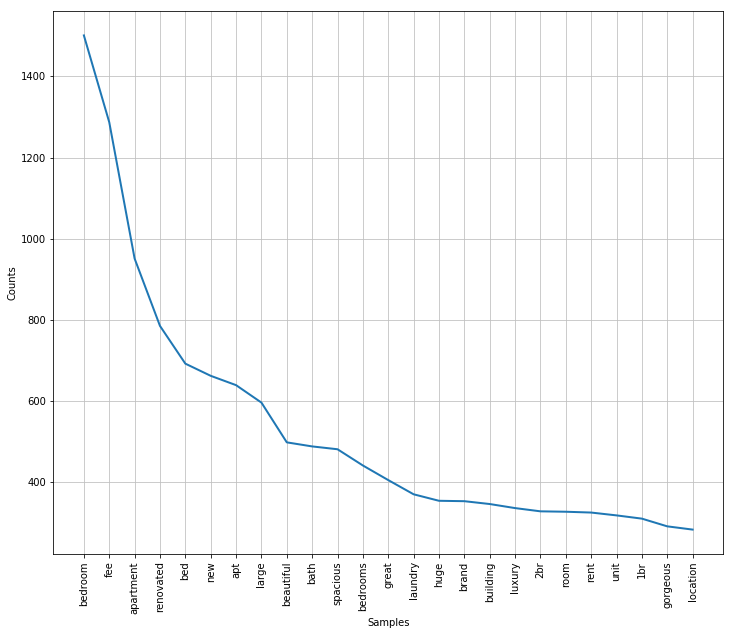

In [60]:
freq = nltk.FreqDist(tokens)
freq.plot(25, cumulative=False)

## Word Cloud
Word clouds are all the rage with NLP so we may as well do one. Below shows the a word cloud, limiting it to the top 200 words.

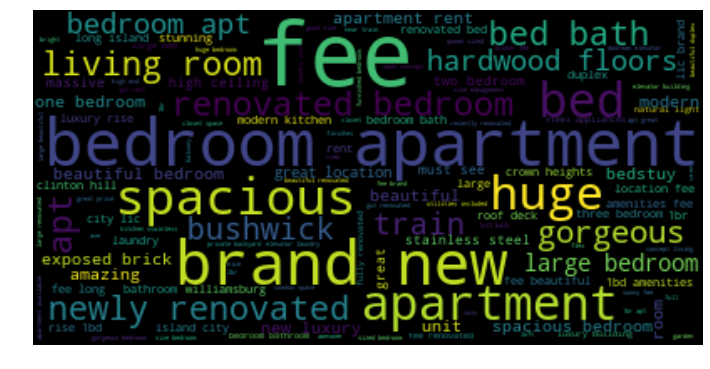

In [61]:
wordcloud = WordCloud(max_words=200).generate(' '.join(tokens))
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Model Time
We need a reproducible pipeline as we will constantly have data flowing in from craigslist. Thus we should create standard functions for processing our dataframe of apartment listings. The following are functions to get our data into a matrix notation where we can fit our models.

### Vocab Pipeline Functions
The following functions take our dataframe of apartment listings and output a text file with the entire vocabulary. That is, any word that is in the titles of our listings will be included. The exceptions will be any words that have a count less than our threshold count (e.g. no words with less than a count of 5). This is to prevent our feature matrix from becoming overly sparse and to only include words in our training set.

In [62]:
# Get all the text from the apartment listings
def load_text(dataframe):
    text = ' '.join(dataframe['name'].tolist())
    
    return text

In [63]:
# Clean the tokens (remove stopwords, punctuation, etc.)
def clean_text(input_text):
    
    # Lower text
    input_text = input_text.lower()
    
    # Tokenize text
    tokens = word_tokenize(input_text)

    # Remove stopwords
    stop_words = stopwords.words('english')
    tokens = [re.sub(r'[^\w\s]|_','', token) for token in tokens if token not in stop_words]

    # Remove short words
    tokens = [token.strip() for token in tokens if len(token) > 2]
    
    return tokens

In [ ]:
# Remove words that don't have at least a minimum number of occurences
def clean_text_min_words(text, min_occurences=3):
    vocab = Counter(text)
    vocab_with_min_occurrences = [word for word, count 
                                      in vocab.items() if count >= min_occurences]
    
    return vocab_with_min_occurrences

In [ ]:
# Export our vocab
def export_vocab(text, filename):
    text_data = '\n'.join(text)
    
    with open(filename, 'w') as write_file:
        write_file.write(text_data)
        write_file.close()

### Text Data  Pipeline
We also need functions to clean an individual listing. These will remove any words not in the vocab above and create a vectorized representation of the apartment listing. We can then run this over our entire dataframe to get a vectorized version of our entire dataset.

In [ ]:
# Clean an individual string
def individual_listing_text(line, vocab):
    
    # Clean the line of text
    clean_line = clean_text(line)
    
    # Keep only words in vocab
    clean_line = [token for token in clean_line if token in vocab]
    
    # Put it back together
    return ' '.join(clean_line)

In [ ]:
# Clean an entire dataframe
def process_all_lines(dataframe, vocab):
    lines = []
    for listing in dataframe['name']:
        cleaned_text = individual_listing_text(listing, vocab)
        lines.append(cleaned_text)
    
    return lines

In [ ]:
# Create our train and test sets
def create_train_and_test(dataframe, vocab, train_portion=.9, mode='count'):

    # Bring in Keras Tokenizer
    tokenizer = Tokenizer()
    
    # Shuffle our data
    dataframe = shuffle(dataframe)
    response = dataframe['bedrooms'].tolist()
    
    # Tokenize the data
    documents = process_all_lines(dataframe, vocab)
    tokenizer.fit_on_texts(documents)
    data_tokenized = tokenizer.texts_to_matrix(documents, mode=mode)
    
    # Split our training and test splits
    number_of_rows = int(.8 * len(data_tokenized))
    X_train = data_tokenized[0:number_of_rows]
    X_test = data_tokenized[number_of_rows:]
    y_train = response[0:number_of_rows]
    y_test = response[number_of_rows:]
    
    # Export test df
    dataframe[number_of_rows:].to_csv('delete.csv')
    
    return X_train, X_test, y_train, y_test

### Tokenize

In [ ]:
# Create our vocab
text_data = load_text(df)
clean_text_data = clean_text(text_data)
vocab = clean_text_min_words(clean_text_data)
export_vocab(vocab, 'vocab.txt')

In [ ]:
X_train, X_test, y_train, y_test = create_train_and_test(df, vocab)

In [ ]:
# Check sizes
print (("""X_Train Size: {}\nX_Test Size: {}\ny_train Size: {}\ny_test Size: {}"""
        .format(X_train.shape, X_test.shape,
                len(y_train), len(y_test))))

X_Train Size: (5677, 1333)
X_Test Size: (1420, 1333)
y_train Size: 5677
y_test Size: 1420


## Fit Models
We will first try a variety of models from scikit-learn on our data now that it is in a place we can easily apply multiple models. The next section uses Keras to fit a deep neural network for (hopefully) increased performance).

### Naive Bayes

In [ ]:
# Define model
clf = MultinomialNB()

# Create Grod
grid = {'alpha': [.0001, .001, .01, .1, 1, 10, 100],
       'fit_prior': [True, False]}

# Fit the model
grid_search = GridSearchCV(clf, 
                           param_grid=grid, 
                           cv=5)

grid_search.fit(X_train, y_train)

# Predict!
preds = grid_search.predict(X_test)
accuracy = accuracy_score(preds, y_test)
report = classification_report(preds, y_test, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print ('------------------')
print(report_df)
print ('------------------')
print ('Achieved an accuracy of: {}'.format(accuracy))
print ('------------------')
print ('Best Model: {}'.format(grid_search.best_estimator_))

------------------
              f1-score  precision    recall  support
1.0           0.733167   0.690141  0.781915    376.0
2.0           0.700624   0.715499  0.686354    491.0
3.0           0.690614   0.733990  0.652079    457.0
4.0           0.680412   0.622642  0.750000     88.0
5.0           0.769231   0.625000  1.000000      5.0
6.0           1.000000   1.000000  1.000000      3.0
micro avg     0.706338   0.706338  0.706338   1420.0
macro avg     0.762341   0.731212  0.811725   1420.0
weighted avg  0.705641   0.709263  0.706338   1420.0
------------------
Achieved an accuracy of: 0.706338028169014
------------------
Best Model: MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)


### Logistic Regression

In [ ]:
# Define model
clf = LogisticRegression()

# Create Grod
grid = {'penalty': ['l1', 'l2'],
       'C': [.1, 1, 10, 100, 1000, 10000]}

# Fit the model
grid_search = GridSearchCV(clf, 
                           param_grid=grid, 
                           cv=5)

grid_search.fit(X_train, y_train)

# Predict!
preds = grid_search.predict(X_test)
accuracy = accuracy_score(preds, y_test)
report = classification_report(preds, y_test, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print ('------------------')
print(report_df)
print ('------------------')
print ('Achieved an accuracy of: {}'.format(accuracy))
print ('------------------')
print ('Best Model: {}'.format(grid_search.best_estimator_))

### LDA

In [ ]:
# Define model
clf = SGDClassifier()

# Create Grod
grid = {'loss': ['hinge', 'log', 'modified_huber'],
        'penalty': ['l1', 'l2'],
        'alpha': [.00001, .0001, .001, .01, ]}

# Fit the model
grid_search = GridSearchCV(clf, 
                           param_grid=grid, 
                           cv=5)

grid_search.fit(X_train, y_train)

# Predict!
preds = grid_search.predict(X_test)
accuracy = accuracy_score(preds, y_test)
report = classification_report(preds, y_test, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print ('------------------')
print(report_df)
print ('------------------')
print ('Achieved an accuracy of: {}'.format(accuracy))
print ('------------------')
print ('Best Model: {}'.format(grid_search.best_estimator_))

## Keras - Neural Network
Let's see if one of those fancy schmancy deep neural networks that all the kids are raving about these days can out perform our traditional models. As of now our old friend Logistic Regression is our best model at an accuracy of 81.7%. First we need to encode our response so it's in the proper format for Keras

### Encode Response

In [ ]:
import keras 

# Train
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encoded = encoder.transform(y_train)
y_train_encoded = np_utils.to_categorical(y_train_encoded)

# Test
encoder.fit(y_test)
y_test_encoded = encoder.transform(y_test)
y_test_encoded = np_utils.to_categorical(y_test_encoded)

# y_train_encoded = keras.utils.to_categorical(y_train)
# y_test_encoded = keras.utils.to_categorical(y_test)

### Create our DNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

input_dim = X_train.shape[1]
model = Sequential()
model.add(Dense(512, input_dim=input_dim, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(256, input_dim=input_dim, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(.5))
model.add(Dense(6))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

### Fit Model

In [ ]:
history = model.fit(X_train, y_train_encoded,
                   epochs=20,
                   verbose=True,
                   validation_split=.9,
                   batch_size=10)

In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Range1d
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6
output_notebook()

# Create dataframe
df_accuracy = pd.DataFrame(data={'epoch': list(range(10)),
                                 'accuracy': history.history['acc'],
                                 'val_acc': history.history['val_acc']
                                })

source = ColumnDataSource(df_accuracy)
p = figure(sizing_mode='stretch_width')
p.line(x='epoch', y='accuracy', source=source, line_width=3, legend='accuracy ')
p.line(x='epoch', y='val_acc', source=source, line_width=3, color='red', legend='validation accuracy ')
p.legend.location = 'bottom_right'
show(p)

### Model Prediction

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))